# Набор данных о кино-индустрии
- Предметная область: Индустрия кино. Анализ финансовых показателей проката, популярности жанров, прогнозирование доходов
- Источник: https://www.kaggle.com/datasets/danielgrijalvas/movies
- Тип данных: Реальные данные 7000+ фильмов за 1986-2020 года с ресурса IMDb

Набор применим для:
- Регрессии: Прогнозирования доходности проката фильма на основе доступных данных
- Кластеризация: по бюджету и дохода фильма, по рейтингу

Признаки:

| Тип данных | Признак | Описание                     |
|------------|---------|------------------------------|
| name       | string  | Название фильма              |
| rating     | string  | Возрастной рейтинг           |
| genre      | string  | Жанр                         |
| year       | int64   | Год выпуска                  |
| released   | string  | Дата и место первого проката |
| score      | float64 | Рейтинг IMDb                 |
| votes      | float64 | Количество голосов           |
| director   | string  | Режиссёр                     |
| writer     | string  | Сценарист                    |
| star       | string  | Главный актёр                |
| country    | string  | Страна                       |
| budget     | float64 | Бюджет                       |
| gross      | float64 | Доход                        |
| company    | string  | Продюсер                     |
| runtime    | float64 | Продолжительность в минутах  |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from typing import Optional

In [2]:
df = pd.read_csv('raw/movies/movies.csv')
df.drop('released', axis=1)
df.sample(10, random_state=228)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
2494,North,PG,Adventure,1994,"July 22, 1994 (United States)",4.5,13000.0,Rob Reiner,Alan Zweibel,Elijah Wood,United States,40000000.0,7182747.0,Castle Rock Entertainment,87.0
4126,The Good Girl,R,Drama,2002,"August 30, 2002 (United States)",6.4,44000.0,Miguel Arteta,Mike White,Jennifer Aniston,United States,8000000.0,16860964.0,Flan de Coco Films,93.0
5649,Kick-Ass,R,Action,2010,"April 16, 2010 (United States)",7.6,535000.0,Matthew Vaughn,Jane Goldman,Aaron Taylor-Johnson,United Kingdom,30000000.0,96188903.0,Marv Films,117.0
3382,Dead Man on Campus,R,Comedy,1998,"August 21, 1998 (United States)",6.0,14000.0,Alan Cohn,Anthony Abrams,Tom Everett Scott,United States,14000000.0,15064946.0,Paramount Pictures,96.0
1573,Tap,PG-13,Comedy,1989,"February 10, 1989 (United States)",6.5,1500.0,Nick Castle,Nick Castle,Gregory Hines,United States,NaN,9114702.0,Beco Films,111.0
7486,Anna,R,Action,2019,"June 21, 2019 (United States)",6.6,69000.0,Luc Besson,Luc Besson,Sasha Luss,France,NaN,31626978.0,Summit Entertainment,118.0
4640,Clifford's Really Big Movie,G,Animation,2004,"April 23, 2004 (United States)",5.4,822.0,Robert C. Ramirez,Rhett Reese,John Ritter,United States,70000.0,3255426.0,Big Red Dog Productions,74.0
2690,While You Were Sleeping,PG,Comedy,1995,"April 21, 1995 (United States)",6.7,95000.0,Jon Turteltaub,Daniel G. Sullivan,Sandra Bullock,United States,17000000.0,182057016.0,Hollywood Pictures,103.0
5337,Miss Pettigrew Lives for a Day,PG-13,Comedy,2008,"March 7, 2008 (United States)",7.1,27000.0,Bharat Nalluri,David Magee,Frances McDormand,United Kingdom,NaN,16724933.0,Focus Features,92.0
932,Lady Jane,PG-13,Biography,1986,"February 7, 1986 (United States)",7.1,6300.0,Trevor Nunn,Chris Bryant,Helena Bonham Carter,United Kingdom,8500000.0,277646.0,Capital Equipment Leasing,136.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


Видно, что многие целочисленные признаки считались как вещественные. Поправим это

In [4]:
# Convert real values to integers if necessary.
float_features = df.select_dtypes(include='float64').columns
float_features = float_features.dropna()
for feature in float_features:
    func = lambda el: pd.isna(el) or (pd.notna(el) and el.is_integer())
    if df[feature].apply(func).all():
        df[feature] = df[feature].astype('Int64')

Год выпуска (year) часто не совпадает с годом первого показа из released, хотя последний является более важным признаком.

Заменим значения year на год из released, если возможно, а released можно будет удалить

In [5]:
regex = r'(\w+) (\d+), (\d+) \((.+)\)'
for value in df['released']:
    if not re.match(regex, str(value)):
        print(value)

df[df['released'].isna()]

November 1980 (United Kingdom)
1981 (United States)
1982 (Japan)
October 1982 (United States)
March 1992 (United States)
January 1983 (United Kingdom)
August 1983 (United States)
February 1984 (United States)
March 1985 (United States)
September 1987 (United States)
March 1986 (United States)
1985 (Taiwan)
1985 (United States)
October 1986 (United States)
February 1987 (United States)
April 1986 (United States)
1987 (United States)
May 1988 (United Kingdom)
September 1987 (United States)
June 1991 (United States)
May 1989 (United States)
May 1988 (United States)
August 1988 (United States)
October 1988 (United States)
October 1988 (United States)
June 1988 (United States)
March 1989 (United States)
July 1989 (United States)
June 1990 (United States)
April 1990 (United States)
May 1990 (United States)
April 1991 (United States)
April 1991 (United States)
December 1991 (United States)
March 1991 (United States)
April 1991 (United States)
January 1991 (United States)
August 1991 (United S

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
5728,Saw: The Final Chapter,R,Crime,2010,NaN,5.6,93000,Kevin Greutert,Patrick Melton,Tobin Bell,NaN,<NA>,<NA>,NaN,<NA>
5730,The Wolfman,R,Drama,2010,NaN,5.8,104000,Joe Johnston,Andrew Kevin Walker,Benicio Del Toro,NaN,<NA>,<NA>,NaN,<NA>


Имеем значения вида '...{year} ({country})' и два вхождения с NaN, которые вскоре всё равно будут удалены, ведь по ним слишком мало информации

In [6]:
def released_to_year(val_str: str) -> Optional[int]:
    val_str = val_str.split('(')[0].strip()
    return int(val_str[-4:])


func = lambda el: released_to_year(el['released']) if str(el['released']) != 'nan' else el['year']
df['year'] = df.apply(func, axis=1)
df = df.drop('released', axis=1)

In [7]:
# Show how many NaN values are in the table.
columns = df.columns
total_rows = df.shape[0]
no_misses_rows = []
for col in columns:
    nan_count = df[col].isna().sum()
    not_empty = df[col].count()
    if not_empty == total_rows:
        no_misses_rows.append(col)
    else:
        print(f'{col}: NaN={nan_count}, Values={not_empty} of {total_rows} rows')
print(f'Cols without any NaN/Empty: {", ".join(no_misses_rows)}')

rating: NaN=77, Values=7591 of 7668 rows
score: NaN=3, Values=7665 of 7668 rows
votes: NaN=3, Values=7665 of 7668 rows
writer: NaN=3, Values=7665 of 7668 rows
star: NaN=1, Values=7667 of 7668 rows
country: NaN=3, Values=7665 of 7668 rows
budget: NaN=2171, Values=5497 of 7668 rows
gross: NaN=189, Values=7479 of 7668 rows
company: NaN=17, Values=7651 of 7668 rows
runtime: NaN=4, Values=7664 of 7668 rows
Cols without any NaN/Empty: name, genre, year, director


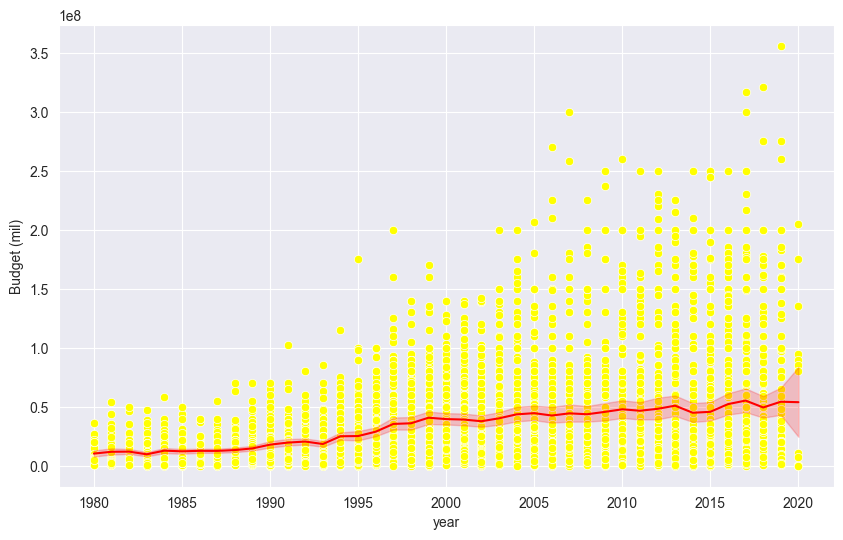

In [8]:
# Show distribution between budget & year.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='budget', color='yellow')
sns.lineplot(data=df, x='year', y='budget', color='red')
plt.ylabel('Budget (mil)')
plt.show()

С годами бюджет фильмов растёт. Попробуем заменить NaN на медианные значения бюджета, опираясь на годовые показатели

In [9]:
# Replace budget NaN values.
mean_per_year = df.groupby('year')['budget'].transform('mean').astype('Int64')
df['budget'] = df['budget'].fillna(mean_per_year)
print('NaN values left:', df.isna().sum().sum())
df.isna().sum().sort_values(ascending=False)

NaN values left: 300


gross       189
rating       77
company      17
runtime       4
score         3
votes         3
writer        3
country       3
star          1
name          0
genre         0
year          0
director      0
budget        0
dtype: int64

Записи с неопределенными показателями дохода можно удалить за ненадобностью, останется относительно мало включений с NaN - их тоже можно удалить

In [10]:
df = df.dropna()
print('NaN values left:', df.isna().sum().sum())

NaN values left: 0


### Анализ и визуализация

In [11]:
df.sample(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
717,Prizzi's Honor,R,Comedy,1985,6.7,23000,John Huston,Richard Condon,Jack Nicholson,United States,12205600,26657534,ABC Motion Pictures,130
5342,Doubt,PG-13,Drama,2008,7.5,124000,John Patrick Shanley,John Patrick Shanley,Meryl Streep,United States,20000000,51699984,Goodspeed Productions,104
423,Curse of the Pink Panther,PG,Comedy,1983,4.3,5700,Blake Edwards,Blake Edwards,David Niven,United Kingdom,11000000,4491986,United Artists,109
5159,The Seeker: the Dark Is Rising,PG,Adventure,2007,4.8,15000,David L. Cunningham,John Hodge,Alexander Ludwig,United States,45000000,31852619,Twentieth Century Fox,99
4738,Land of the Dead,R,Horror,2005,6.2,93000,George A. Romero,George A. Romero,John Leguizamo,United States,15000000,47074133,Universal Pictures,93
6557,A Most Violent Year,R,Action,2015,7.0,68000,J.C. Chandor,J.C. Chandor,Oscar Isaac,United States,20000000,12007070,Before The Door Pictures,125
4071,Unfaithful,R,Drama,2002,6.7,83000,Adrian Lyne,Claude Chabrol,Richard Gere,France,50000000,119137784,Fox 2000 Pictures,124
627,Heartbreakers,R,Drama,1984,5.9,456,Bobby Roth,Bobby Roth,Peter Coyote,United States,12780629,148750,Jethro Films Production,98
2019,Sólo con tu pareja,Not Rated,Comedy,1992,6.9,3500,Alfonso Cuarón,Alfonso Cuarón,Daniel Giménez Cacho,Mexico,20491222,9915,Esperanto Filmoj,94
6852,Don't Breathe,R,Crime,2016,7.1,235000,Fede Alvarez,Fede Alvarez,Stephen Lang,United States,9900000,157830487,Screen Gems,88


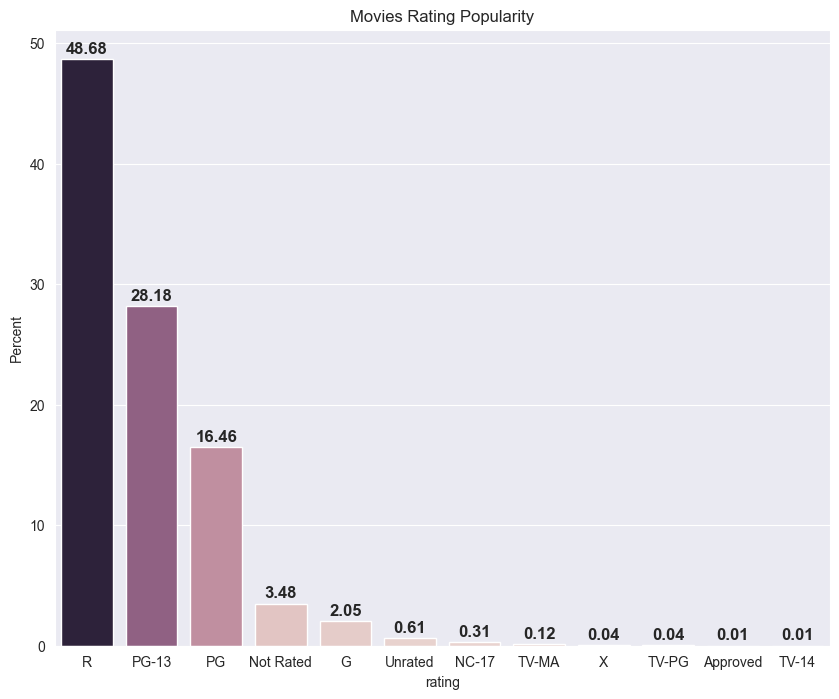

In [12]:
# G - General Audiences (no restrictions);
# PG - Parental Guidance Suggested;
# PG-13 - 13+;
# R - 17+;
# NC-17 - 18+.

data = df['rating'].value_counts()
data = round(data / sum(data) * 100, 2)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data.index, y=data,
    hue=data, legend=False
)
plt.ylabel('Percent')
plt.title(f'Movies Rating Popularity')
for ind, val in enumerate(data):
    ax.annotate(
        f'{val:.2f}', xy=(ind, val+0.5), ha='center',
        fontsize=12, fontweight='bold'
    )

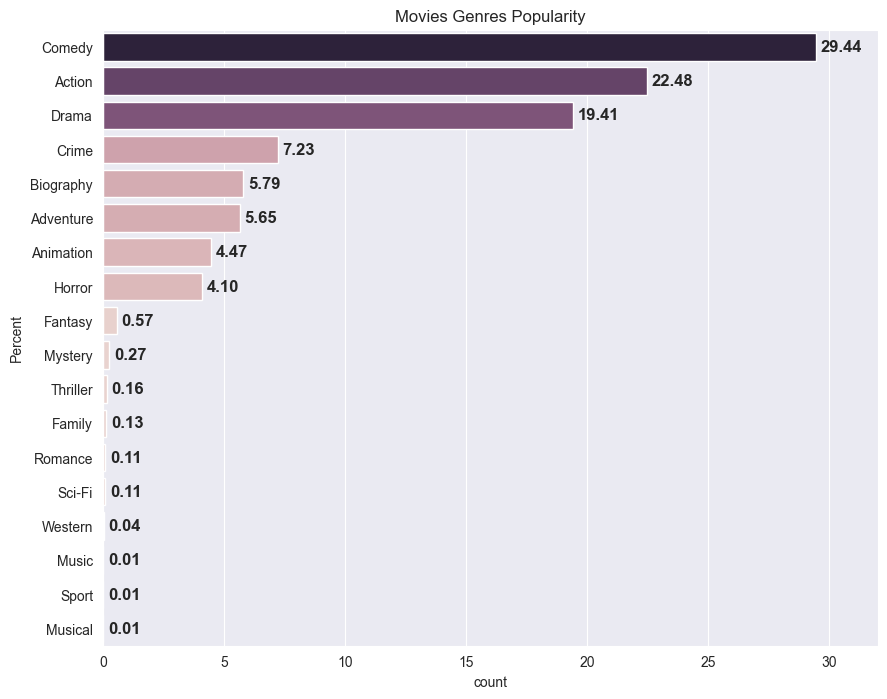

In [13]:
data = df['genre'].value_counts()
data = round(data / sum(data) * 100, 2)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data,
    y=data.index,
    hue=data,
    legend=False
)
ax.set_xlim(0, 32)
plt.ylabel('Percent')
plt.title('Movies Genres Popularity')
for i, value in enumerate(data):
    ax.annotate(
        f'{value:.2f}', xy=(value+0.2, i), va='center',
        fontsize=12, fontweight='bold'
    )

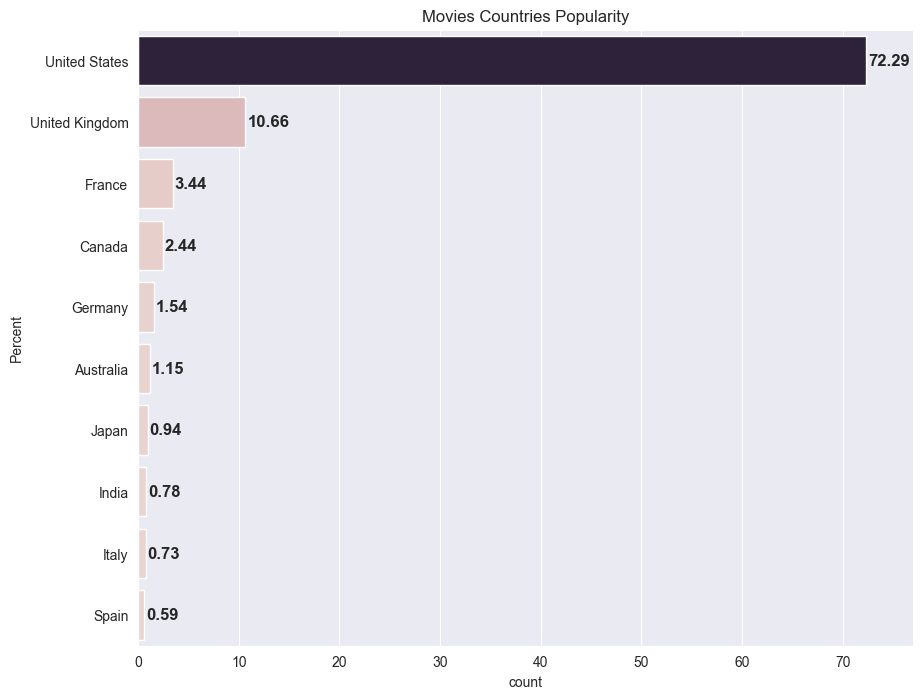

In [14]:
data = df['country'].value_counts()
data = round(data / sum(data) * 100, 2)
data = data[:10]

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=data,
    y=data.index,
    hue=data,
    legend=False
)
ax.set_xlim(0, 77)
plt.ylabel('Percent')
plt.title('Movies Countries Popularity')
for i, value in enumerate(data):
    ax.annotate(
        f'{value:.2f}', xy=(value+0.2, i), va='center',
        fontsize=12, fontweight='bold'
    )

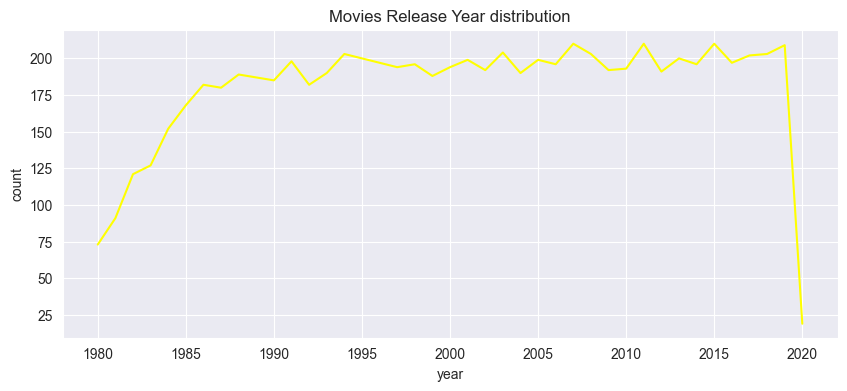

In [15]:
data = df['year'].value_counts()

plt.figure(figsize=(10, 4))
ax = sns.lineplot(x=data.index, y=data, color='yellow')
plt.title('Movies Release Year distribution')
plt.show()

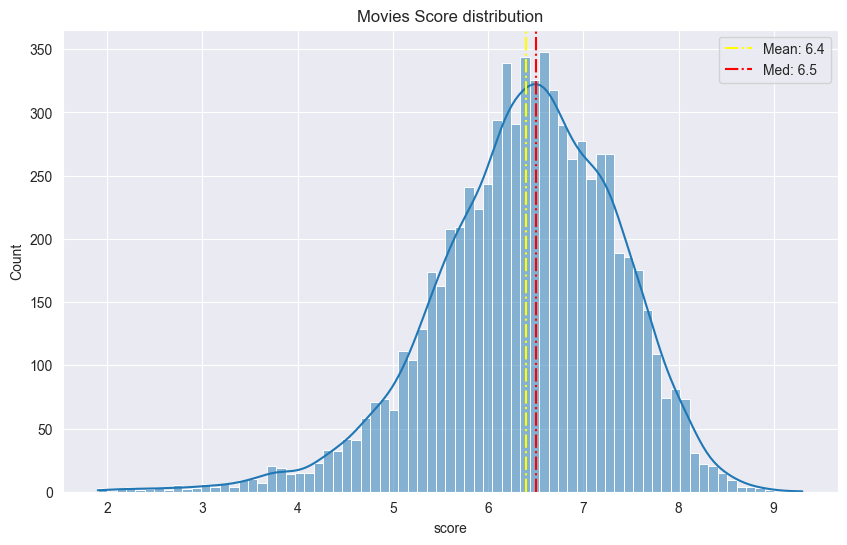

The score data skew: -0.61


In [16]:
data = df['score']

plt.figure(figsize=(10, 6))
plt.title('Movies Score distribution')

# Histogram.
bins = 10 * (data.max() - data.min()) + 1
sns.histplot(data, kde=True, bins=int(bins))

# Median and Mean lines.
mean, med = data.mean(), data.median()
plt.axvline(mean, color='yellow', linestyle='-.', label=f'Mean: {mean:.1f}')
plt.axvline(med, color='red', linestyle='-.', label=f'Med: {med:.1f}')

plt.legend()
plt.show()

print(f'The score data skew: {df["score"].skew(): 0.2f}')

In [17]:
def print_top(df_col: pd.Series, param: str, cnt: int = 5) -> None:
    print(f'Top {cnt} {param} by number of movies')
    for k, v in df_col.value_counts().head(cnt).items():
        print(f'\t{k}: {v}')
    print()

print_top(df['director'], 'directors')
print_top(df['writer'], 'writers')
print_top(df['company'], 'companies')

Top 5 directors by number of movies
	Woody Allen: 38
	Clint Eastwood: 31
	Steven Spielberg: 27
	Directors: 25
	Ron Howard: 24

Top 5 writers by number of movies
	Woody Allen: 37
	Stephen King: 31
	Luc Besson: 25
	John Hughes: 25
	William Shakespeare: 15

Top 5 companies by number of movies
	Universal Pictures: 376
	Warner Bros.: 332
	Columbia Pictures: 332
	Paramount Pictures: 319
	Twentieth Century Fox: 240



In [18]:
print('Top 15 movies of all time (by IMDb rating)')
filtered = df['score'].nlargest(15)
df.loc[filtered.index, ['year', 'name', 'score']]

Top 15 movies of all time (by IMDb rating)


,year,name,score
2443,1994,The Shawshank Redemption,9.3
5243,2008,The Dark Knight,9.0
2247,1994,Schindler's List,8.9
2444,1994,Pulp Fiction,8.9
4245,2003,The Lord of the Rings: The Return of the King,8.9
2445,1994,Forrest Gump,8.8
3444,1999,Fight Club,8.8
3845,2001,The Lord of the Rings: The Fellowship of the Ring,8.8
5643,2010,Inception,8.8
2,1980,Star Wars: Episode V - The Empire Strikes Back,8.7


### Зависимости признаков. Матрица корреляции.

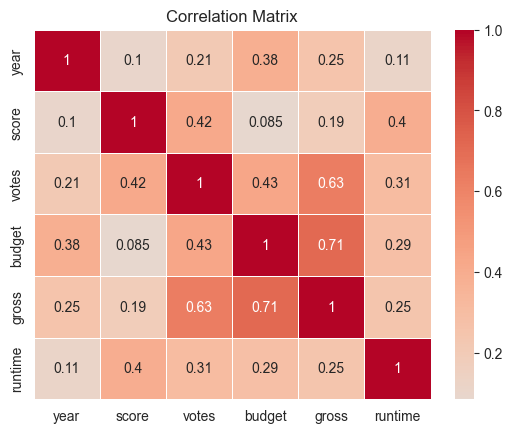

In [19]:
df_numeric = df.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Из матрицы видно:
1. Сильную положительную зависимость gross от budget = 0.71
2. Сильную положительную зависимость gross от votes  = 0.63

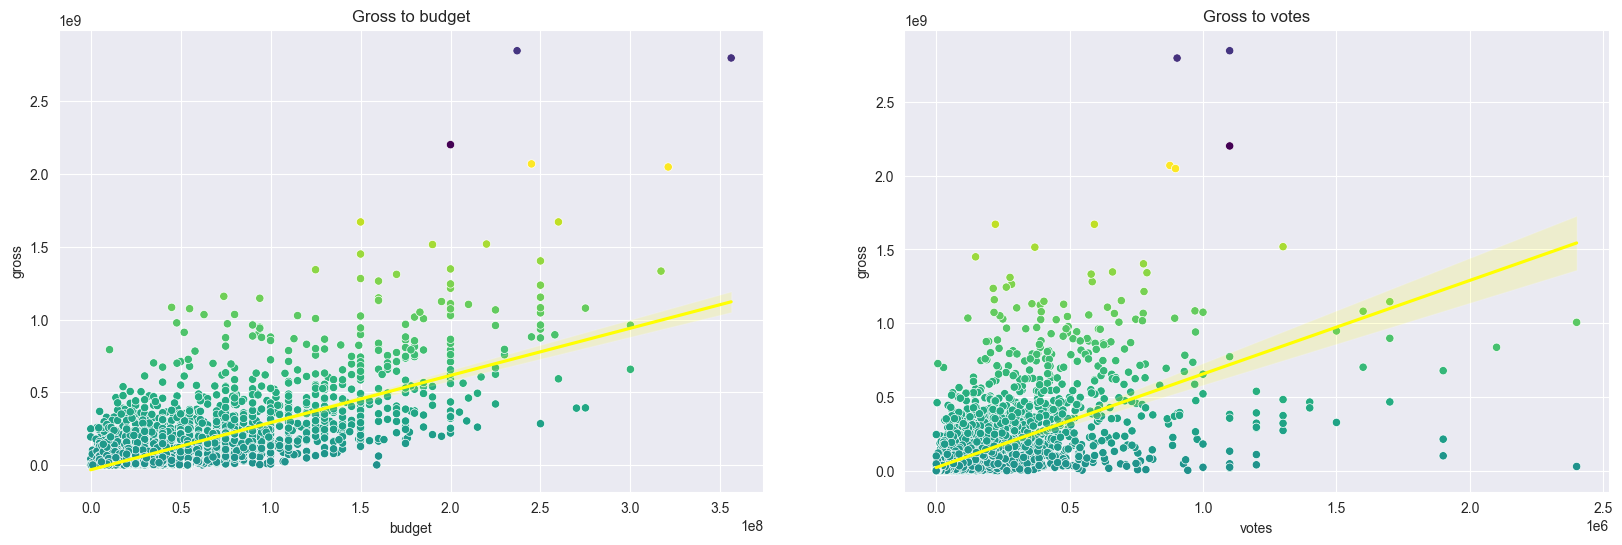

In [20]:
plt.figure(figsize=(20, 6))

# Plot 1: Gross/Budget.
plt.subplot(1, 2, 1)
sns.scatterplot(x='budget', y='gross', data=df, hue=df['gross'].astype(int), legend=False, palette='viridis')
sns.regplot(x='budget', y='gross', data=df, scatter=False, color='yellow')
plt.title('Gross to budget')

# Plot 2: Gross/Votes.
plt.subplot(1, 2, 2)
sns.scatterplot(x='votes', y='gross', data=df, hue=df['gross'].astype(int), legend=False, palette='viridis')
sns.regplot(x='votes', y='gross', data=df, scatter=False, color='yellow')
plt.title('Gross to votes')

plt.show()

Выводы:
1. Чем сильнее растёт бюджет, тем больше доход;
2. Чем больше оценок (тем больше просмотрело людей), тем больше доход.

In [21]:
# New feature: profit.
df['profit'] = df['gross'] - df['budget']
df.sample(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,profit
3129,Children of Heaven,PG,Drama,1999,8.3,68000,Majid Majidi,Majid Majidi,Mohammad Amir Naji,Iran,180000,933933,Kanun parvaresh fekri,89,753933
2152,Leap of Faith,PG-13,Comedy,1992,6.1,13000,Richard Pearce,Janus Cercone,Steve Martin,United States,20491222,23369283,Paramount Pictures,108,2878061
7027,Ae Dil Hai Mushkil,Not Rated,Drama,2016,5.8,22000,Karan Johar,Karan Johar,Ranbir Kapoor,India,52211949,31668920,ADHM Films,158,-20543029
4181,Whale Rider,PG-13,Drama,2003,7.5,40000,Niki Caro,Niki Caro,Keisha Castle-Hughes,New Zealand,3500000,41062976,South Pacific Pictures,101,37562976
2526,Don Juan DeMarco,PG-13,Comedy,1995,6.7,49000,Jeremy Leven,Lord Byron,Johnny Depp,United States,25000000,68792531,New Line Cinema,97,43792531
1196,Gardens of Stone,R,Drama,1987,6.4,5200,Francis Ford Coppola,Nicholas Proffitt,James Caan,United States,12575437,5262047,TriStar Pictures,111,-7313390
6604,Tammy,R,Comedy,2014,4.9,49000,Ben Falcone,Melissa McCarthy,Melissa McCarthy,United States,20000000,100375432,RatPac-Dune Entertainment,97,80375432
2949,Everyone Says I Love You,R,Comedy,1997,6.7,36000,Woody Allen,Woody Allen,Woody Allen,United States,20000000,9759200,Miramax,101,-10240800
4264,The Italian Job,PG-13,Action,2003,7.0,350000,F. Gary Gray,Troy Kennedy-Martin,Donald Sutherland,United States,60000000,176070171,Paramount Pictures,111,116070171
2924,Freeway,R,Comedy,1997,6.8,27000,Matthew Bright,Matthew Bright,Reese Witherspoon,United States,3000000,295493,The Kushner-Locke Company,102,-2704507


In [22]:
# Save dataframe for further use.
df.to_csv(r'raw/movies/movies_clean.csv', index=False)

### Категоризация, нормализация, подбор числа кластеров K-Means

In [23]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans


# Encode labels.
label_encoder = LabelEncoder()
categorical_features = ['rating', 'genre', 'country']
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])
    
# Get numerical features, normalize.
df_numeric = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df_numeric)

# Search for optimal k.
k_range = range(1, 15)
kmeans = [KMeans(n_clusters=i) for i in k_range]
score = [kmeans[i-1].fit(df_numeric).score(df_numeric) for i in k_range]

C:\Users\bestc\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\bestc\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


### Кластеризация K-Means

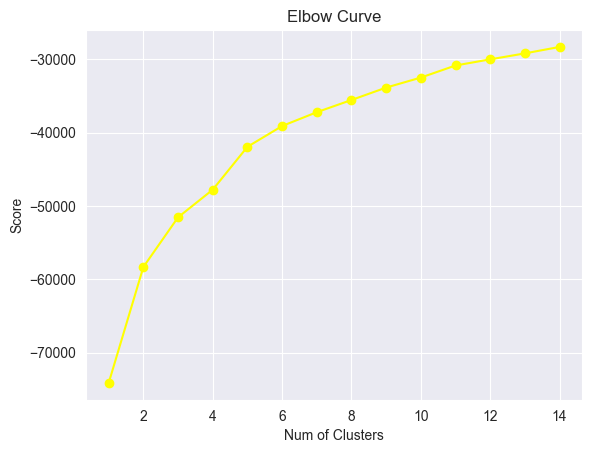

In [24]:
# Show kmeans.
plt.plot(k_range, score, marker='o', color='yellow')
plt.xlabel('Num of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [25]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(df_numeric)
len(kmeans.labels_)

7412

In [26]:
df_clusters = df.copy()
df_clusters['cluster'] = kmeans.labels_
df_clusters.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,profit,cluster
0,The Shining,6,6,1980,8.4,927000,Stanley Kubrick,Stephen King,Jack Nicholson,52,19000000,46998772,Warner Bros.,146,27998772,3
1,The Blue Lagoon,6,1,1980,5.8,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,53,4500000,58853106,Columbia Pictures,104,54353106,1
2,Star Wars: Episode V - The Empire Strikes Back,4,0,1980,8.7,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,53,18000000,538375067,Lucasfilm,124,520375067,0
3,Airplane!,4,4,1980,7.7,221000,Jim Abrahams,Jim Abrahams,Robert Hays,53,3500000,83453539,Paramount Pictures,88,79953539,1
4,Caddyshack,6,4,1980,7.3,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,53,6000000,39846344,Orion Pictures,98,33846344,1


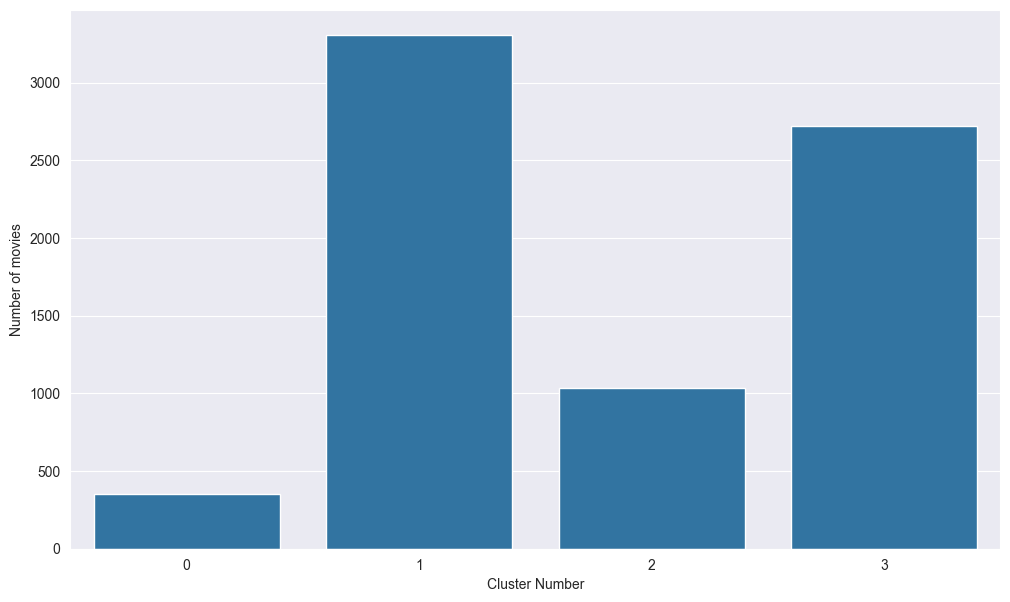

In [27]:
plt.figure(figsize=(12,7))
axis = sns.barplot(
    x=np.arange(0,optimal_k,1), 
    y=df_clusters.groupby(['cluster']).count()['budget'].values
)
x=axis.set_xlabel('Cluster Number')
y=axis.set_ylabel('Number of movies')


In [28]:
df_numeric = df_clusters.select_dtypes(include=[np.number])
df_numeric = df_numeric.groupby('cluster').mean().round(2)

for cluster, count in df_clusters['cluster'].value_counts().sort_index().items():
    print(f'Cluster #{cluster} size: {count}')
    
df_numeric

Cluster #0 size: 351
Cluster #1 size: 3304
Cluster #2 size: 1034
Cluster #3 size: 2723


,rating,genre,year,score,votes,country,budget,gross,runtime,profit
cluster,,,,,,,,,,
0,4.71,1.29,2009.31,7.21,539574.07,51.04,135089692.31,657652147.9,125.58,522562455.59
1,5.21,4.01,1992.92,5.98,25146.02,52.55,17956022.44,23168968.59,100.36,5212946.15
2,5.05,3.76,2003.34,6.74,55897.27,14.06,31827364.93,32898341.81,111.87,1070976.88
3,5.31,3.19,2008.43,6.67,125768.95,52.42,42511946.71,89642728.59,112.03,47130781.88


Можно увидеть следующие группы:
- №0 и №2: Два наибольших кластера - большинство хороших фильмов. Первые выделяются хорошими прибылями profit
- №1: Небольшой кластер - фильмы с малыми прибылями
- №3: Наименьший кластер - фильмы с наибольшими финансовыми показателями

Посмотрим на представителей каждой группы.

In [29]:
# Cluster 0.
df_view = df_clusters.drop(columns=['rating', 'genre', 'country', 'budget', 'gross'])
df_view[df_view['cluster'] == 0].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
4480,The Passion of the Christ,2004,7.2,221000,Mel Gibson,Benedict Fitzgerald,Jim Caviezel,Icon Productions,127,582054506,0
6892,Jason Bourne,2016,6.6,213000,Paul Greengrass,Paul Greengrass,Matt Damon,Universal Pictures,123,295484914,0
5891,Sherlock Holmes: A Game of Shadows,2011,7.5,429000,Guy Ritchie,Michele Mulroney,Robert Downey Jr.,Warner Bros.,129,418848418,0
6046,The Hunger Games,2012,7.2,862000,Gary Ross,Gary Ross,Jennifer Lawrence,Lionsgate,142,616394724,0
6311,Despicable Me 2,2013,7.3,377000,Pierre Coffin,Cinco Paul,Steve Carell,Universal Pictures,98,894766005,0


In [30]:
# Cluster 1.
df_view[df_view['cluster'] == 1].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
3671,Sexy Beast,2001,7.3,57000,Jonathan Glazer,Louis Mellis,Ray Winstone,Recorded Picture Company (RPC),89,-29079323,1
3331,Six-String Samurai,1998,6.6,7000,Lance Mungia,Jeffrey Falcon,Jeffrey Falcon,HSX Films,91,-1853875,1
1850,The Addams Family,1991,6.9,140000,Barry Sonnenfeld,Charles Addams,Anjelica Huston,Orion Pictures,99,161502426,1
1474,Harlem Nights,1989,6.1,21000,Eddie Murphy,Eddie Murphy,Eddie Murphy,Eddie Murphy Productions,116,30864870,1
533,Purple Rain,1984,6.5,20000,Albert Magnoli,Albert Magnoli,Prince,Warner Bros.,111,63063155,1


In [31]:
# Cluster 2.
df_view[df_view['cluster'] == 2].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
5126,Saw IV,2007,5.9,144000,Darren Lynn Bousman,Patrick Melton,Tobin Bell,Twisted Pictures,93,129352633,2
3194,Mr. Nice Guy,1998,6.2,26000,Sammo Kam-Bo Hung,Fibe Ma,Jackie Chan,GH Pictures,88,-17145414,2
5154,Once,2007,7.8,112000,John Carney,John Carney,Glen Hansard,Bórd Scannán na hÉireann,86,20786722,2
4321,High Tension,2005,6.8,69000,Alexandre Aja,Alexandre Aja,Cécile de France,Alexandre Films,91,-38257016,2
7335,High Life,2019,5.8,31000,Claire Denis,Claire Denis,Robert Pattinson,Alcatraz Films,113,-52107692,2


In [32]:
# Cluster 3.
df_view[df_view['cluster'] == 3].sample(5)

,name,year,score,votes,director,writer,star,company,runtime,profit,cluster
6014,30 Minutes or Less,2011,6.1,96000,Ruben Fleischer,Michael Diliberti,Jesse Eisenberg,Columbia Pictures,83,12662632,3
5993,Salmon Fishing in the Yemen,2012,6.8,63000,Lasse Hallström,Simon Beaufoy,Ewan McGregor,UK Film Council,107,-13653619,3
6759,The Diary of a Teenage Girl,2015,6.9,30000,Marielle Heller,Phoebe Gloeckner,Bel Powley,Caviar,102,-224867,3
5620,The Messenger,2009,7.1,34000,Oren Moverman,Alessandro Camon,Ben Foster,Oscilloscope,113,-4904583,3
7576,Crypto,2019,5.3,3700,John Stalberg Jr.,Carlyle Eubank,Beau Knapp,Yale Productions,105,-54220285,3


Действительно, можно наблюдать группу самых удачных прокатов, группу самых неудачных и две посередине. Разница между последними двумя в среднем порядке доходов (разница в десяток)